In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from networkx.utils import py_random_state
import random, time, pickle, multiprocessing, matplotlib, copy, itertools

In [2]:
def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g


def comp_g(g, compartment_name):
    '''
        returns nodes in compartment compartment_name
    '''
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]


def temp_q_contact_tracing(G, alpha, p, alpha_prime):
    '''
        returns number of nodes in different compartments S, I, Q, R
        after runing the SIR+Q process
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    
    while new_seeds:
     #check if there is no infection left
        t = [temp_q_quarantine_infection(seed, G, alpha, p, alpha_prime) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
        
        #leaving Q at any time
        for qs_node in  comp_g(G, 'QS'):
            if random.random() <= alpha_prime:
                G.nodes()[qs_node]['type'] = 'S'     
        for qi_node in comp_g(G, 'QI'):
                if random.random() <= alpha_prime:
                    G.nodes()[qi_node]['type'] = 'R'
    
    S, I, R, Qi, Qs = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'QI'), comp_g(G, 'QS')

    return [len(S)/N, len(I)/N, len(R)/N, len(R)/N + p*(len(Qi)+len(Qs))/N, len(R)/N + len(Qi)/N]


def temp_q_quarantine_infection(infected_node, G, alpha, p, alpha_prime):
    '''
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            rand_alpha = random.random()
            rand_p = random.random()
            if rand_alpha <= alpha:
                G.nodes()[ne]['type'] = 'QI' if rand_p <= p else 'QS'
            else:
                if rand_p <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    return new_infected_nodes

In [4]:
ens = 10**1
N = 10**5
average_degree = 6 
c_1_list = [2,3,4]
alphas =  [0, .25, 0.5]
p_range = np.linspace(0.1,0.70, 50)

#Gs = [regular_clique(N, average_degree, c) for c in c_1_list]
Gs = Parallel(n_jobs=max(12, multiprocessing.cpu_count()))(delayed(regular_clique)(N, average_degree, c) for c in c_1_list)

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-04/e0d50272/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


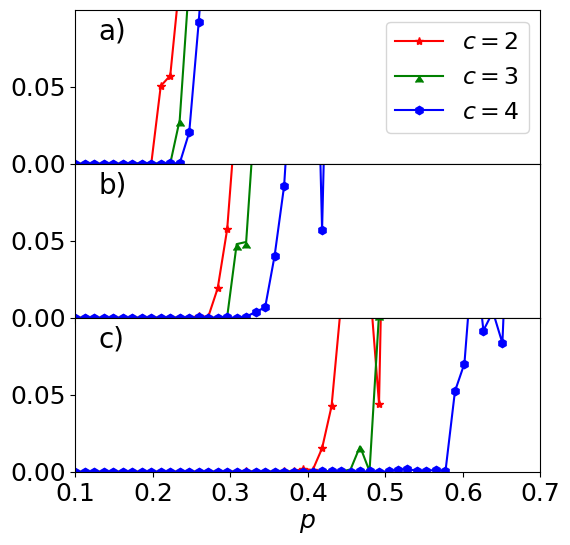

In [5]:
alpha_prime = 0.5  #alpha_prime = 0 produces the old results

fig = plt.figure(figsize=(6, 6))
labels = ['a)', 'b)', 'c)', 'd)']
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for _al in range(len(alphas)):
    axs[_al].text(0.05, 0.95, labels[_al], transform=axs[_al].transAxes, fontsize=20, va='top')

    CT = lambda p_range, G, alpha, alpha_prime: [temp_q_contact_tracing(G, alpha, p, alpha_prime)[4] for p in p_range]
    data = [np.mean(np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(CT)(p_range, G, alphas[_al], alpha_prime) for en in range(ens))), axis = 0) for G in Gs]
    np.save(str(N)+'_'+str(alpha_prime)+'_'+str(alphas[_al])+'temp_q_fig3A', data)
    
    colors = ['r', 'g', 'b', 'm'] 
    axs[_al].plot(p_range, data[0], marker ='*', label = r'$c = 2$', color = colors[0])
    axs[_al].plot(p_range, data[1], marker = 6, label =r'$c = 3$', color = colors[1])
    axs[_al].plot(p_range, data[2], marker= 'h', label = r'$c = 4$', color = colors[2])

    axs[_al].set_xlim(0.1, .7)
    axs[_al].set_xlabel(r'$p$', fontsize = 18)
    axs[_al].tick_params(axis='y', labelsize=18)
    axs[_al].set_ylim(0, .1)
    if _al==0:
        axs[_al].set_yticks([0.00, 0.05])


axs[0].legend(fontsize = 17)
axs[2].tick_params(axis='x', labelsize=18)
#fig.suptitle(r'Outbreak Size', fontsize = 22)
plt.savefig(str(N)+'_'+str(alpha_prime)+'_'+str(alphas)+'_temp_q.pdf')   

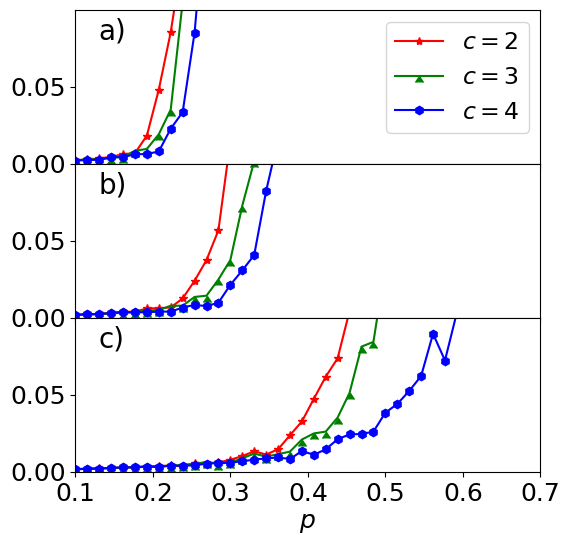

In [29]:
alpha_prime = 0.9  #alpha_prime = 0 produces the old results

fig = plt.figure(figsize=(6, 6))
labels = ['a)', 'b)', 'c)', 'd)']
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for _al in range(len(alphas)):
    axs[_al].text(0.05, 0.95, labels[_al], transform=axs[_al].transAxes, fontsize=20, va='top')

    CT = lambda p_range, G, alpha, alpha_prime: [temp_q_contact_tracing(G, alpha, p, alpha_prime)[4] for p in p_range]
    data = [np.mean(np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(CT)(p_range, G, alphas[_al], alpha_prime) for en in range(ens))), axis = 0) for G in Gs]
    #np.save(str(N)+'_'+str(alpha_prime)+'_'+str(alphas[_al])+'temp_q_fig3A', data)
    
    colors = ['r', 'g', 'b', 'm'] 
    axs[_al].plot(p_range, data[0], marker ='*', label = r'$c = 2$', color = colors[0])
    axs[_al].plot(p_range, data[1], marker = 6, label =r'$c = 3$', color = colors[1])
    axs[_al].plot(p_range, data[2], marker= 'h', label = r'$c = 4$', color = colors[2])

    axs[_al].set_xlim(0.1, .7)
    axs[_al].set_xlabel(r'$p$', fontsize = 18)
    axs[_al].tick_params(axis='y', labelsize=18)
    axs[_al].set_ylim(0, .1)
    if _al==0:
        axs[_al].set_yticks([0.00, 0.05])


axs[0].legend(fontsize = 17)
axs[2].tick_params(axis='x', labelsize=18)
#fig.suptitle(r'Outbreak Size', fontsize = 22)
plt.savefig(str(N)+'_'+str(alpha_prime)+'_'+str(alphas)+'_temp_q.pdf')   